In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
import sys
path=os.path.join(sys.path[0],"datas")
file_names=os.listdir(path)
data=pd.DataFrame({})
for i in range(len(file_names)):
  df=pd.read_csv(path+'/'+file_names[i])
  data=pd.concat([data,df])
data.drop('Unnamed: 0',axis=1,inplace=True)
data2=data.select_dtypes(exclude=['object'])
data2=data2.drop(['watchers_count','watchers'],axis=1)
data2.isna().sum(axis=0)

private                          0
owner.public_repos               0
owner.public_gists               0
owner.followers                  0
owner.following                  0
fork                             0
forks                            0
size                             0
stargazers_count                 0
has_issues                       0
has_projects                     0
has_downloads                    0
has_wiki                         0
has_pages                        0
has_discussions                  0
forks_count                      0
archived                         0
disabled                         0
open_issues_count                0
allow_forking                    0
is_template                      0
web_commit_signoff_required      0
score                          900
dtype: int64

In [ ]:
data3=data2.drop('score',axis=1)
x=data3.loc[:,data3.columns!='stargazers_count'].values
y=data3['stargazers_count'].values
N=x.shape
x=x.astype(np.float64)
y=y.astype(np.float64)

Text(0.5, 1.0, 'Hisstogram of output variable')

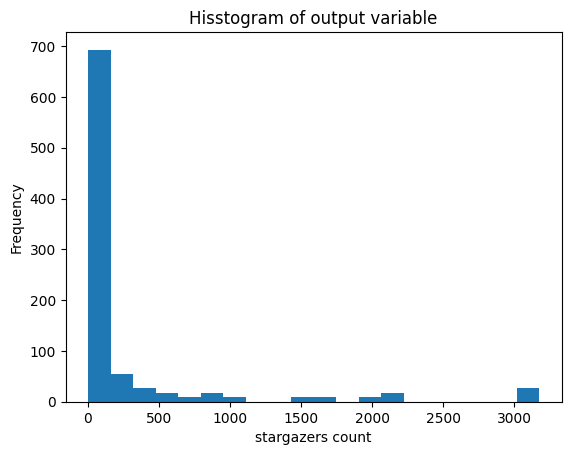

In [ ]:
plt.hist(y,20)
plt.ylabel('Frequency')
plt.xlabel('stargazers count')
plt.title('Hisstogram of output variable')

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test,idx_train,idx_test = train_test_split(x, y,np.arange(len(y)), 
                                                    test_size=0.2, random_state=42)


In [ ]:
#x_pca_train=x_train-np.mean(x_train)
#x_pca_test=x_test-np.mean(x_train)
pca=PCA(n_components=N[1])
pca.fit(x_train)
print(np.sum(pca.explained_variance_ratio_[:1]))
print(np.sum(pca.explained_variance_ratio_[:2]))
x_tr=pca.transform(x_train)
x_ts=pca.transform(x_test)

0.8849304374661286
0.9998712922219435


## Linear Regression

In [ ]:
reg = LinearRegression().fit(x_tr, y_train)
reg.score(x_ts,y_test)

0.927152825565507

Linear Regression R2 score:  0.927152825565507
Linear Regression MSE:  36704.05679579922
Linear Regression MAE:  98.27249653128443


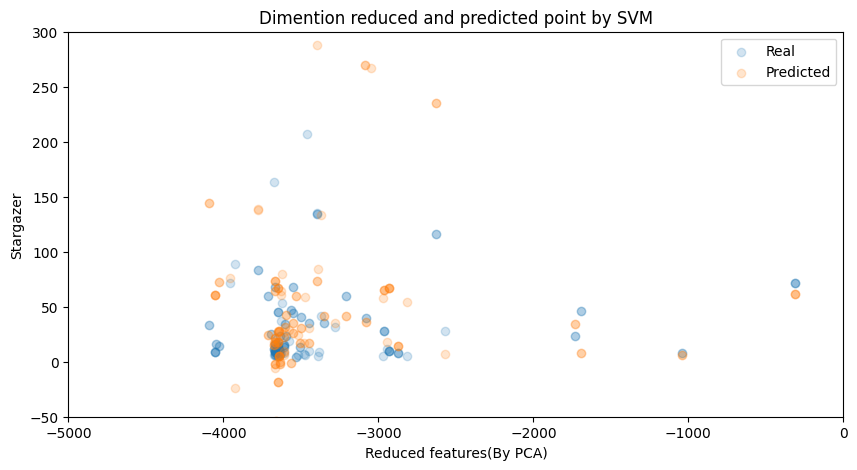

In [ ]:
pca=PCA(n_components=1)
x_pca=pca.fit_transform(x)

reg = LinearRegression().fit(x_train, y_train)
y_pred=reg.predict(x_test)

print("Linear Regression R2 score: ",reg.score(x_test,y_test))
print("Linear Regression MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("Linear Regression MAE: ",metrics.mean_absolute_error(y_test,y_pred))

plt.figure(figsize=(10,5))
plt.title('Dimention reduced and predicted point by SVM')
plt.xlim((-5000,0))
plt.ylim((-50,300))
plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
plt.legend(['Real','Predicted'])
plt.xlabel('Reduced features(By PCA)')
plt.ylabel('Stargazer')
plt.show()

## Best Features

Text(0.5, 1.0, 'Score-Best Subset of Features')

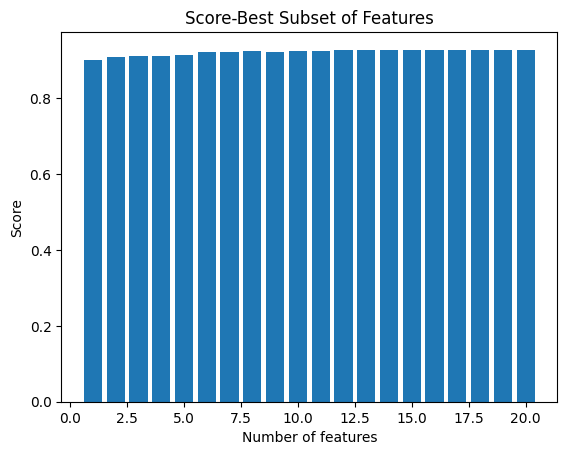

In [ ]:
df=data3.loc[:,data3.columns!='stargazers_count']
feature_names=df.columns
acc=[]
best_feature_names=[]
for i in range(N[1]-1):
  reg = LinearRegression()
  sfs = SequentialFeatureSelector(reg, n_features_to_select=i+1)
  sfs.fit(x_train,y_train)
  best_feature_names.append(feature_names[sfs.get_support()])
  s_xtr=sfs.transform(x_train)
  s_xts=sfs.transform(x_test)
  reg1=LinearRegression()
  reg1.fit(s_xtr,y_train)
  acc.append(reg1.score(s_xts,y_test))

plt.bar(np.arange(N[1]-1)+1,acc)
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.title('Score-Best Subset of Features')

In [ ]:
print(best_feature_names[0])
print(acc[0])

Index(['forks'], dtype='object')
0.900047405952285


## SVM

SVM R2 score:  0.8768052876254382
SVM MSE:  62071.669286283664
SVM MAE:  111.19211150149913


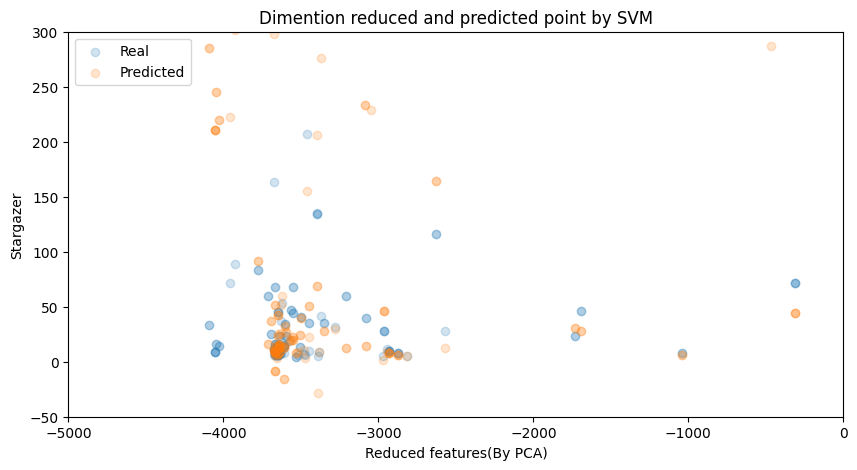

In [ ]:
pca=PCA(n_components=1)
x_pca=pca.fit_transform(x)
from sklearn.svm import SVR

model_svr=SVR(kernel="linear")
model_svr.fit(x_train,y_train)
y_pred=model_svr.predict(x_test)
print("SVM R2 score: ",model_svr.score(x_test,y_test))
print("SVM MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("SVM MAE: ",metrics.mean_absolute_error(y_test,y_pred))

plt.figure(figsize=(10,5))
plt.title('Dimention reduced and predicted point by SVM')
plt.xlim((-5000,0))
plt.ylim((-50,300))
plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
plt.legend(['Real','Predicted'])
plt.xlabel('Reduced features(By PCA)')
plt.ylabel('Stargazer')
plt.show()

## Decision Tree

Decision Tree R2 score:  0.9999999998277155
Decision Tree MSE:  8.680555555555556e-05
Decision Tree MAE:  0.0006944444444444445


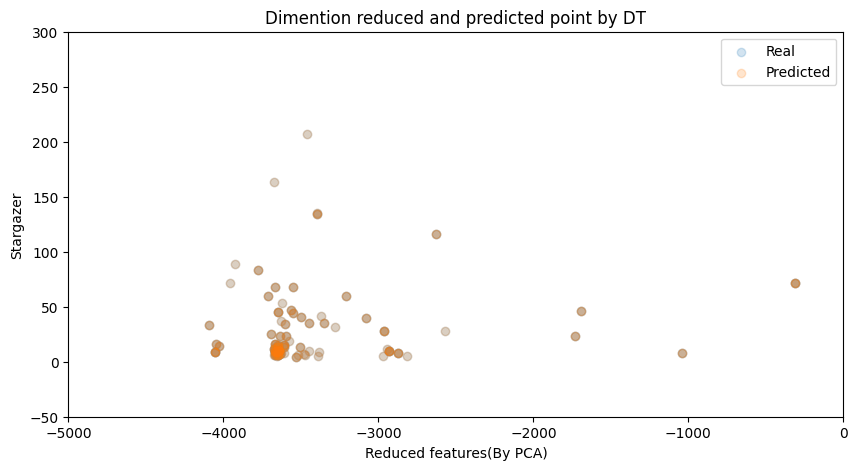

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt_ergressor=DecisionTreeRegressor(criterion="squared_error")
dt_ergressor.fit(x_train,y_train)
y_pred=dt_ergressor.predict(x_test)
print("Decision Tree R2 score: ",dt_ergressor.score(x_test,y_test))
print("Decision Tree MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("Decision Tree MAE: ",metrics.mean_absolute_error(y_test,y_pred))


plt.figure(figsize=(10,5))
plt.title('Dimention reduced and predicted point by DT')
plt.xlim((-5000,0))
plt.ylim((-50,300))
plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
plt.legend(['Real','Predicted'])
plt.xlabel('Reduced features(By PCA)')
plt.ylabel('Stargazer')
plt.show()

## KNN

KNN R2 score:  0.9993279301954245
KNN MSE:  338.62244444444497
KNN MAE:  3.1255555555555614


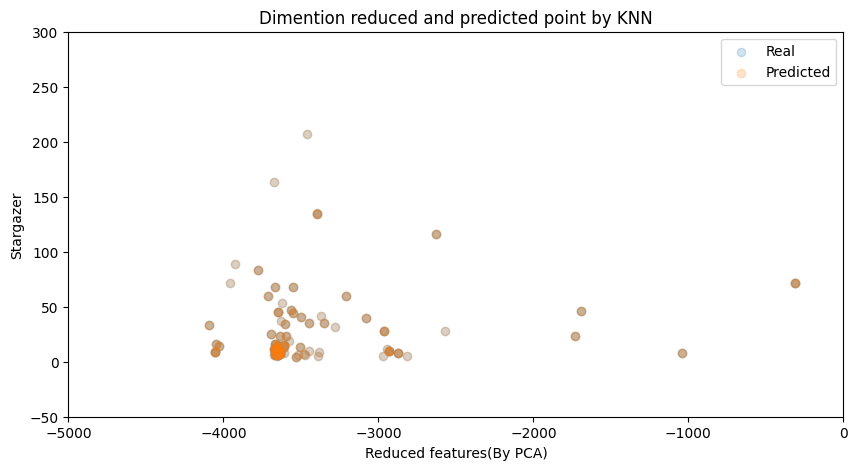

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_ergressor=KNeighborsRegressor(n_neighbors=5)
knn_ergressor.fit(x_train,y_train)
y_pred=knn_ergressor.predict(x_test)
print("KNN R2 score: ",knn_ergressor.score(x_test,y_test))
print("KNN MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("KNN MAE: ",metrics.mean_absolute_error(y_test,y_pred))

plt.figure(figsize=(10,5))
plt.title('Dimention reduced and predicted point by KNN')
plt.xlim((-5000,0))
plt.ylim((-50,300))
plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
plt.legend(['Real','Predicted'])
plt.xlabel('Reduced features(By PCA)')
plt.ylabel('Stargazer')
plt.show()

## Multilayer Perceptron

MLP R2 score:  0.9313501826531153
MLP MSE:  34589.217968737205
MLP MAE:  97.27817357126058


c:\Users\meyss\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


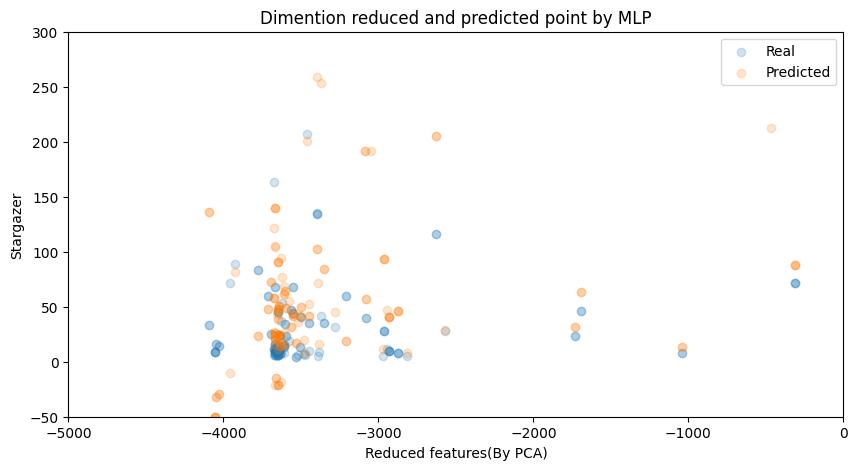

In [ ]:
from sklearn.neural_network import MLPRegressor
MLP_ergressor=MLPRegressor(hidden_layer_sizes=(300,100,50),activation="relu",solver="lbfgs"
      ,learning_rate= "adaptive", learning_rate_init= 0.3)
MLP_ergressor.fit(x_train,y_train)
y_pred=MLP_ergressor.predict(x_test)
print("MLP R2 score: ",MLP_ergressor.score(x_test,y_test))
print("MLP MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("MLP MAE: ",metrics.mean_absolute_error(y_test,y_pred))

plt.figure(figsize=(10,5))
plt.title('Dimention reduced and predicted point by MLP')
plt.xlim((-5000,0))
plt.ylim((-50,300))
plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
plt.legend(['Real','Predicted'])
plt.xlabel('Reduced features(By PCA)')
plt.ylabel('Stargazer')
plt.show()

## AdaBoost Regressor

AdaBoost R2 score:  0.9848811331143742
AdaBoost MSE:  7617.642731732122
AdaBoost MAE:  61.63860444058777


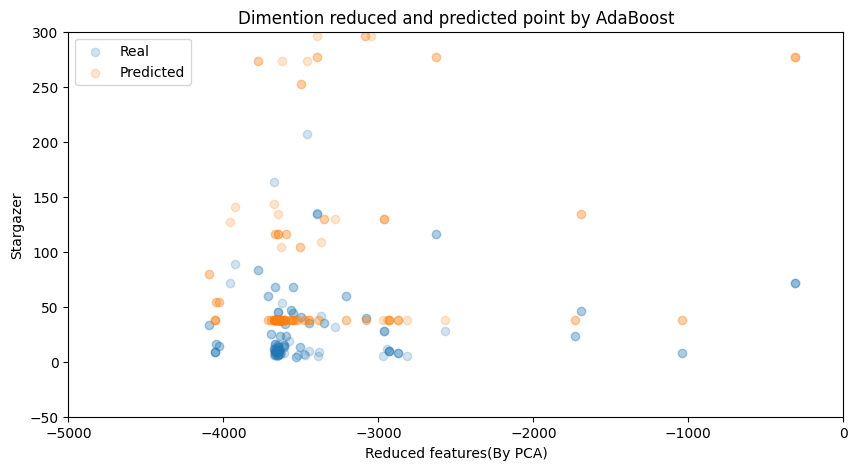

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
AdaBoost_ergressor=AdaBoostRegressor(n_estimators=50)
AdaBoost_ergressor.fit(x_train,y_train)
y_pred=AdaBoost_ergressor.predict(x_test)
print("AdaBoost R2 score: ",AdaBoost_ergressor.score(x_test,y_test))
print("AdaBoost MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("AdaBoost MAE: ",metrics.mean_absolute_error(y_test,y_pred))


plt.figure(figsize=(10,5))
plt.title('Dimention reduced and predicted point by AdaBoost')
plt.xlim((-5000,0))
plt.ylim((-50,300))
plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
plt.legend(['Real','Predicted'])
plt.xlabel('Reduced features(By PCA)')
plt.ylabel('Stargazer')
plt.show()

## Bagging (Ensemble Learning)

Bagging (Ensemble Learning) R2 score:  0.9999902903828886
Bagging (Ensemble Learning) MSE:  4.8921916421440494
Bagging (Ensemble Learning) MAE:  0.4460204184704173


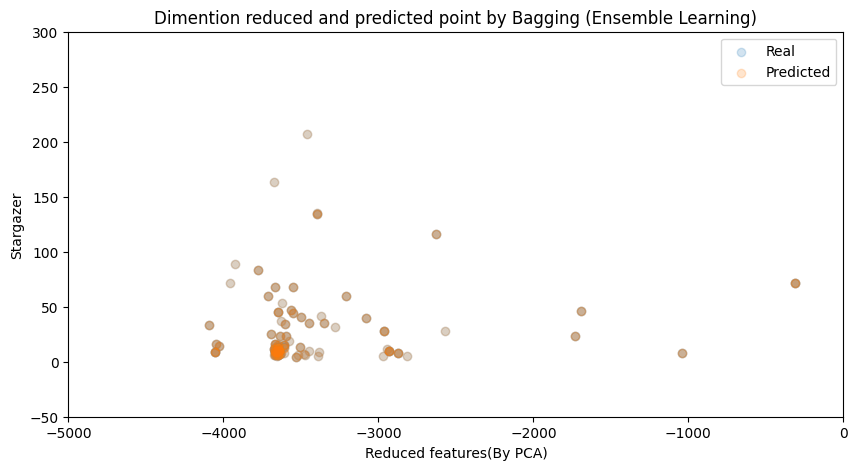

In [ ]:
from sklearn.ensemble import BaggingRegressor
bagging_ergressor=BaggingRegressor(n_estimators=50)
bagging_ergressor.fit(x_train,y_train)
y_pred=bagging_ergressor.predict(x_test)
print("Bagging (Ensemble Learning) R2 score: ",bagging_ergressor.score(x_test,y_test))
print("Bagging (Ensemble Learning) MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("Bagging (Ensemble Learning) MAE: ",metrics.mean_absolute_error(y_test,y_pred))


plt.figure(figsize=(10,5))
plt.title('Dimention reduced and predicted point by Bagging (Ensemble Learning)')
plt.xlim((-5000,0))
plt.ylim((-50,300))
plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
plt.legend(['Real','Predicted'])
plt.xlabel('Reduced features(By PCA)')
plt.ylabel('Stargazer')
plt.show()

## XGBoost

[23:02:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost R2 score:  0.9999999277211743
XGBoost MSE:  0.036417694215112484
XGBoost MAE:  0.015353094206915961


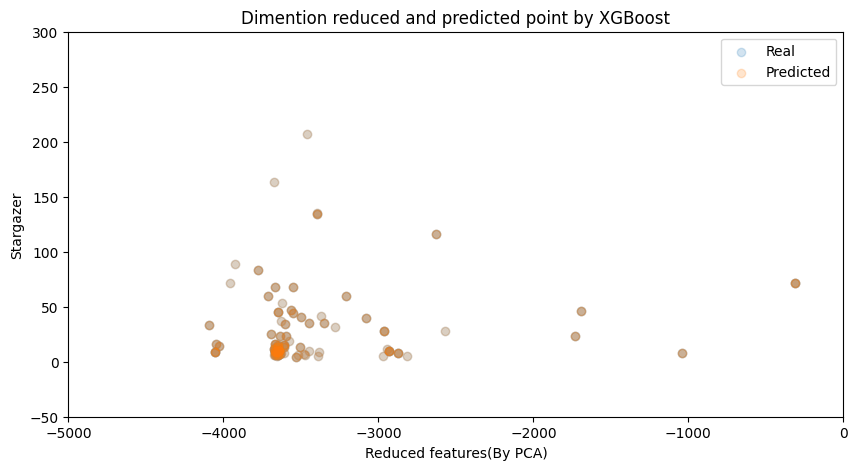

In [ ]:
import xgboost as xgb

xgb_ergressor=xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_ergressor.fit(x_train,y_train)
y_pred=xgb_ergressor.predict(x_test)
print("XGBoost R2 score: ",xgb_ergressor.score(x_test,y_test))
print("XGBoost MSE: ",metrics.mean_squared_error(y_test,y_pred))
print("XGBoost MAE: ",metrics.mean_absolute_error(y_test,y_pred))

plt.figure(figsize=(10,5))
plt.title('Dimention reduced and predicted point by XGBoost')
plt.xlim((-5000,0))
plt.ylim((-50,300))
plt.scatter(x=x_pca[idx_test],y=y[idx_test],alpha=0.2)
plt.scatter(x=x_pca[idx_test],y=y_pred,alpha=0.2)
plt.legend(['Real','Predicted'])
plt.xlabel('Reduced features(By PCA)')
plt.ylabel('Stargazer')
plt.show()